# Implementation for Section 6

**author: ** weiya<szcfweiya@gmail.com>

**date: ** Dec. 28, 2017

This notebook is to implement [the Section 6 in Chapter 11 of ESL](https://esl.hohoweiya.xyz/11%20Neural%20Networks/11.6%20Example%20of%20Simulated%20Data/index.html)


# Data
$$
Y=\sigma(a_1^TX)+\sigma(a_2^TX)+\epsilon
$$
where $X^T=(X_1, X_2)$, and $X_j\sim N(0,1)$. For the parameters, $a_1=(3,3),a_2=(3,-3)$. For the gaussian noise $\epsilon$, we choose its variance to satisfy
$$
\frac{Var(f(X))}{Var(\epsilon)}=4
$$

In [123]:
import numpy as np
from scipy.special import expit
# set up
num_train = 100
num_test = 10000
# generate X
np.random.seed(123)
X_train = np.random.normal(0, 1, (num_train, 2))
X_test = np.random.normal(0, 1, (num_test, 2))
# parameters
a_1 = np.array([3, 3])
a_2 = np.array([3, -3])
epsi_var = np.var(X_train) / 4
epsi_train = np.random.normal(0, np.sqrt(epsi_var), num_train)
epsi_test = np.random.normal(0, np.sqrt(epsi_var), num_test)

In [124]:
# generate y
y_train = expit(X_train.dot(a_1)) + expit(X_train.dot(a_2)) + epsi_train
y_test = expit(X_test.dot(a_1)) + expit(X_test.dot(a_2)) + epsi_test
y_train = y_train.reshape(num_train, 1)
y_test = y_test.reshape(num_test, 1)

## Prediction
$$
Z_m=\sigma(\alpha_{0m}+\alpha_m^TX)\qquad m=1,\ldots, M\\
T_k = \beta_{0k}+\beta_k^TZ\qquad k=1,\ldots,K\\
f_k(X) = g_k(T) = T
$$

## Loss function
$$
R = \sum\limits_{i=1}^N\sum\limits_{k=1}^K(y_{ik}-f_k(x_i))^2
$$

## BP
$$
\begin{align}
\frac{\partial R_i}{\partial \beta_{km}}&=\delta_{ki}z_{mi}\\
\frac{\partial R_i}{\partial \alpha_{m\ell}}&=s_{mi}x_{i\ell}\\
\frac{\partial R_i}{\partial \beta_{0k}}&=\delta_{ki}\\
\frac{\partial R_i}{\partial \alpha_{0m}}&=s_{mi}
\end{align}
$$
where
$$
s_{mi}=\sigma'(\alpha_{0m}+\alpha_m^Tx_i)\sum\limits_{k=1}^K\beta_{km}\delta_{ki}
$$
$$
\delta_{ki}=-2(y_{ik}-f_k(x_i))g'_k(\beta_{0k}+\beta_k^Tz_i)
$$
and we have 
$$
\begin{align}
\sigma'(v)&=\sigma(v)\cdot(1-\sigma(v))\\
g_k'(T)&=1
\end{align}
$$
**Note:** for softmax function, we have $g_k'(T) = g_k(T)\cdot (1-g_k(T)))$

In [142]:
def train_model(nn_hdim, num_passes = 5000, print_loss = False, reg_lambda = 0.0):
    # initialize
    # np.random.seed(123)
    alpha = np.random.randn(2, nn_hdim) / np.sqrt(2)
    a = np.zeros((1, nn_hdim))
    beta = np.random.randn(nn_hdim, 1) / np.sqrt(nn_hdim)
    b = np.zeros((1, 1))
    
    
    gamma = 0.0005
    
    model = {}
    
    # gradient descent
    for i in xrange(0, num_passes):
        # forward pass
        z = expit(X_train.dot(alpha) + a)
        T = z.dot(beta) + b
        pred = T
        
        # calculate the loss
        if print_loss and i%100 == 0:
            data_loss = np.sum(np.square(pred-y_train)) + reg_lambda/2 * (np.sum(np.square(alpha)) + np.sum(np.square(beta)))
            print "Loss after iteration %i: %f" %(i, 1./num_train * data_loss)
        
        # back propagation
        delta = -2*(y_train-pred)
        dbeta = (z.T).dot(delta)
        db = np.sum(delta, axis=0, keepdims=True)
        s = delta.dot(beta.T) * (z*(1-z))
        dalpha = np.dot(X_train.T, s)
        da = np.sum(s, axis=0)
        
        # add regularization term
        dbeta += reg_lambda * beta
        dalpha += reg_lambda * alpha
        
        # gradient descent
        alpha += -gamma * dalpha
        a += -gamma * da
        beta += -gamma * dbeta
        b += -gamma * db
        
        # assign new parameters to the model
        model = {'alpha': alpha, 'a': a, 'beta': beta, 'b':b}
    return model

In [138]:
# test
def test_model(model):
    alpha, a, beta, b = model['alpha'], model['a'], model['beta'], model['b']
    # forward pass
    z = expit(X_test.dot(alpha) + a)
    T = z.dot(beta) + b
    pred = T
    pred_loss = 1./num_test * np.sum(np.square(pred-y_test)) 
    return pred_loss

In [139]:
# vary the number of hidden units
num_cases = 10
num_repeat = 10
mat_loss = np.zeros((num_repeat, num_cases))
for i in xrange(0, 10):
    for j in xrange(0, num_repeat):
        model = train_model(i+1)
        mat_loss[j, i] = test_model(model)

In [113]:
%matplotlib inline
import matplotlib.pyplot as plt

**The Bayes rate for regression with squared error is the error variance.**

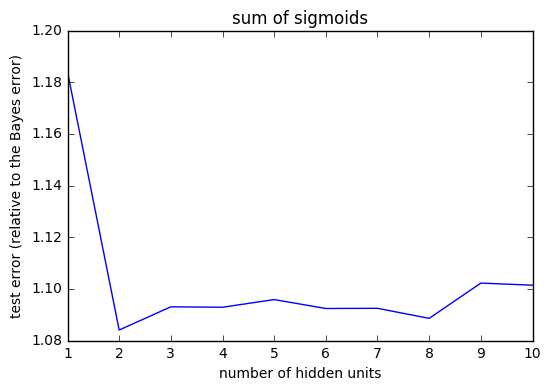

In [140]:
plt.plot([x+1 for x in range(10)], mat_loss.mean(axis=0)/epsi_var)
plt.ylabel('test error (relative to the Bayes error)')
plt.xlabel('number of hidden units')
plt.title('sum of sigmoids')
plt.show()

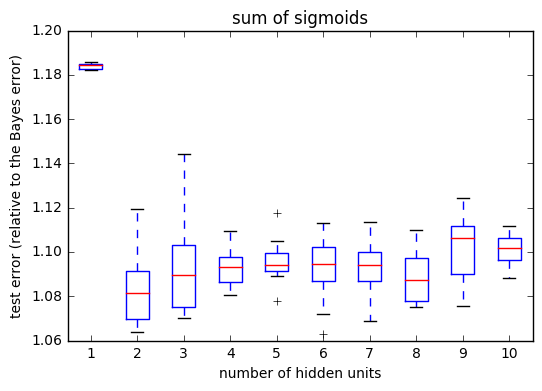

In [149]:
# boxplot
plt.boxplot(mat_loss/epsi_var)
plt.ylabel('test error (relative to the Bayes error)')
plt.xlabel('number of hidden units')
plt.title('sum of sigmoids')
plt.show()

In [151]:
# weight decay
# vary the number of hidden units
mat_loss_reg = np.zeros((num_repeat, num_cases))
for i in xrange(0, 10):
    for j in xrange(0, num_repeat):
        model = train_model(i+1, reg_lambda=0.1)
        mat_loss_reg[j, i] = test_model(model)

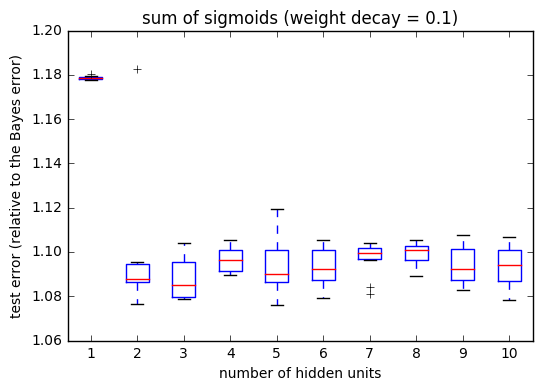

In [152]:
# boxplot
plt.boxplot(mat_loss_reg/epsi_var)
plt.ylabel('test error (relative to the Bayes error)')
plt.xlabel('number of hidden units')
plt.title('sum of sigmoids (weight decay = 0.1)')
plt.show()

In [147]:
# vary the rate of weight decay
seq_lambda = np.arange(0.0, 0.2, 0.02)
mat_loss_vary_lambda = np.zeros((num_repeat, len(seq_lambda)))
for i in xrange(0, len(seq_lambda)):
    for j in xrange(0, num_repeat):
        model = train_model(10, reg_lambda=seq_lambda[i])
        mat_loss_vary_lambda[j, i] = test_model(model)

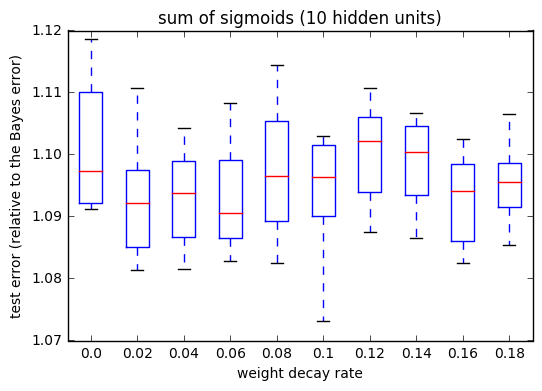

In [154]:
# boxplot
plt.boxplot(mat_loss_vary_lambda/epsi_var)
plt.ylabel('test error (relative to the Bayes error)')
plt.xlabel('weight decay rate')
plt.xticks([x+1 for x in range(10)], seq_lambda)
plt.title('sum of sigmoids (10 hidden units)')
plt.show()